In [16]:
!pip install haversine
!pip install gurobipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 55.4 MB/s eta 0:00:00


In [17]:
import pandas
from google.colab import files

import numpy as np
from scipy.spatial import distance_matrix
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point
from numpy import random

from haversine import haversine
from gurobipy import *

In [5]:
f = files.upload()

Saving 구글맵 학원 좌표.csv to 구글맵 학원 좌표.csv


In [6]:
data = pandas.read_csv("구글맵 학원 좌표.csv",encoding = "euc-kr" ,index_col=0)
data.head()

,학원명,도로명주소,위도,경도
0,생명을살리는수학창의교육보습학원,서울특별시 광진구 구의강변로 106,37.539900,127.094819
1,시엘음악학원,서울특별시 광진구 용마산로21길 27,37.563485,127.085939
2,성신에듀학원,서울특별시 광진구 자양로22길 24,37.539490,127.084692
3,청람보습학원,서울특별시 광진구 용마산로 100,37.562608,127.087319
4,상명보습학원,서울특별시 광진구 자양로 181-1,37.543898,127.084563


In [7]:
data.describe()

,위도,경도
count,787.000000,787.000000
mean,37.544268,127.086007
std,0.009766,0.009999
min,37.528579,127.062148
25%,37.537397,127.079211
50%,37.541938,127.086913
75%,37.551361,127.094136
max,37.568024,127.110947


In [10]:
points = np.array([list(i) for i in zip(data['경도'], data['위도'])])

points

array([[127.0948193,  37.5399001],
       [127.0859389,  37.5634854],
       [127.0846921,  37.5394904],
       ...,
       [127.0939444,  37.5404134],
       [127.0683161,  37.5447084],
       [127.0896293,  37.557691 ]])

## 학원 - 본인 위치 기준으로 : 근처 500m 이내(도보 8분) 학원 수, 학원 정원 합, 휴게음식점 수, 교통사고 건수, 횡단보도 개수 (top 이 후보) -> mlcp

In [20]:
for i in range(len(data)) :
    cnt = 0
    location1 = tuple([data.loc[i, '위도'], data.loc[i, '경도']])
    for j in range(len(data)):
        location2 = tuple([data.loc[j, '위도'], data.loc[j, '경도']])
        if haversine(location1, location2)*1000<=500 :
            cnt += 1
    data.loc[i, '근처학원수'] = cnt - 1 # 본인과 본인 거리도 계산하여 cnt++함 -> cnt - 1 필요

**MCLP 사용**

⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️

In [21]:
def generate_candidate_sites(points,M=100):
    '''
    Generate M candidate sites with the convex hull of a point set
    Input:
        points: a Numpy array with shape of (N,2)
        M: the number of candidate sites to generate
    Return:
        sites: a Numpy array with shape of (M,2)
    '''
    hull = ConvexHull(points)
    polygon_points = points[hull.vertices]
    poly = Polygon(polygon_points)
    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    while len(sites) < M:
        random_point = Point([random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            sites.append(random_point)
    return np.array([(p.x,p.y) for p in sites])

def mclp(points,K,radius,M):
    """
    Solve maximum covering location problem
    Input:
        points: input points, Numpy array in shape of [N,2]
        K: the number of sites to select
        radius: the radius of circle
        M: the number of candidate sites, which will randomly generated inside
        the ConvexHull wrapped by the polygon
    Return:
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        f: the optimal value of the objective function
    """
    print('----- Configurations -----')
    print('  Number of points %g' % points.shape[0])
    print('  K %g' % K)
    print('  Radius %g' % radius)
    print('  M %g' % M)
    import time
    start = time.time()
    sites = generate_candidate_sites(points,M)
    J = sites.shape[0]
    I = points.shape[0]
    D = distance_matrix(points,sites)
    mask1 = D<=radius
    D[mask1]=1
    D[~mask1]=0
    # Build model
    m = Model()
    # Add variables
    x = {}
    y = {}
    for i in range(I):
      y[i] = m.addVar(vtype=GRB.BINARY, name="y%d" % i)
    for j in range(J):
      x[j] = m.addVar(vtype=GRB.BINARY, name="x%d" % j)

    m.update()
    # Add constraints
    m.addConstr(quicksum(x[j] for j in range(J)) == K)

    for i in range(I):
        m.addConstr(quicksum(x[j] for j in np.where(D[i]==1)[0]) >= y[i])

    m.setObjective(quicksum(y[i]for i in range(I)),GRB.MAXIMIZE)
    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('  Optimal coverage points: %g' % m.objVal)
    
    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            # print v.varName,v.x
            if v.x==1 and v.varName[0]=="x":
               solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites,m.objVal

def plot_input(points):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

def plot_result(points,opt_sites,radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    plt.scatter(opt_sites[:,0],opt_sites[:,1],c='C1',marker='+')
    for site in opt_sites:
        circle = plt.Circle(site, radius, color='C1',fill=False,lw=2)
        ax.add_artist(circle)
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

----- Configurations -----
  Number of points 787
  K 10
  Radius 0.2
  M 781
----- Output -----
  Running time : 0.7458646297454834 seconds
  Optimal coverage points: 787


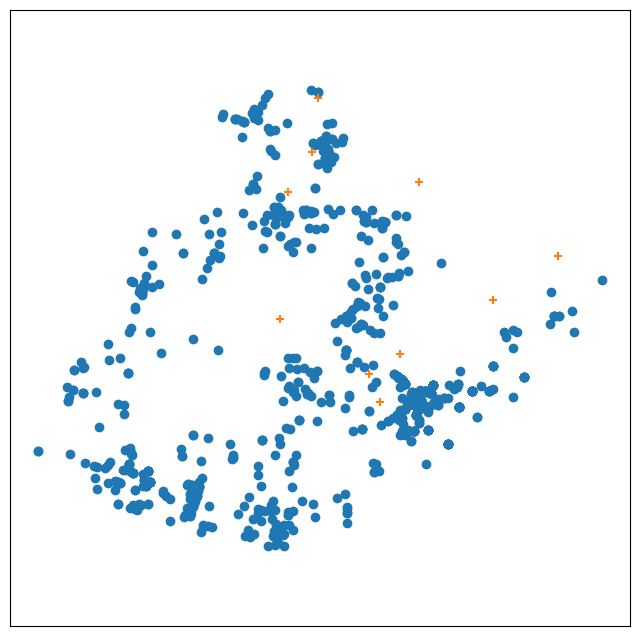

In [24]:
K = 10 # 선정할 최적입지 개수
radius = 0.2 # 각각 좌표에서 원의 반지름
M = 781 # 후보지개수는 학원개수 == 781개

# Run mclp opt_sites is the location of optimal sites and f is the points covered
opt_sites,f = mclp(points,K,radius,M)

# Plot the result
plot_result(points,opt_sites,radius)